In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser
from dynamic_env.env_config import EnvConfig


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from grid_world.graph import Graph
from grid_world.node import Node
from grid_world.tasks import *
from copy import deepcopy
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageChops
from mpl_toolkits.axes_grid1 import ImageGrid

import networkx as nx
import pygraphviz as pgv
import IPython.display 

In [2]:
def locomotion_style(n, pop_id):
    if pop_id%4 == 0:
        n.attr['style']="solid"
    if pop_id%4 == 1:
        n.attr['style']="dashed"
    if pop_id%4 == 2:
        n.attr['style']="dotted"
    if pop_id%4 == 3:
        n.attr['style']="bold"
        n.attr['penwidth']=5
        
def snk_style(n, pop_id):
    if pop_id in [7, 8, 9, 10, 13,16, 19, 22, 25, 26, 27, 28] :
        n.attr['style']="bold"
        n.attr['penwidth']=5
    elif pop_id in [14, 15, 20, 21]:
        n.attr['style']="dotted"
    else:
        n.attr['style']="solid"

    
        
def create_gen_tree(d_historical, graph, g_id, curr_depth):
    
    hist = d_historical[g_id]
    p1, p2 = hist.parent_1, hist.parent_2
#     g_name = f"{g_id} ({hist.pop_id})"
    g_name = f"{g_id}"
    
    if curr_depth == 0:
        n = graph.get_node(g_name)    
        snk_style(n, hist.pop_id)



        return
    
    if p1 == -1 or p2 == -1:
        
        A.add_node(g_name, color="purple")
        return
    
    p1_name = f"{p1}"
    p2_name = f"{p2}"

#     p1_name = f"{p1}"
#     p2_name = f"{p2}"
    
    
    
    if p1 == p2:
        graph.add_edge(p1_name, g_name, color="green")
    else:
        graph.add_edge(p1_name, g_name, color="blue")
        graph.add_edge(p2_name, g_name, color="red")
    
    
    n = graph.get_node(g_name)    
    snk_style(n, hist.pop_id)

    
    create_gen_tree(d_historical, graph, p1, curr_depth-1)
    create_gen_tree(d_historical, graph, p2, curr_depth-1)

In [3]:
def get_robot(genome, neat_config, env, genome_type):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(5, genome_type)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, 5)
        
    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    
    env = evogym.envs.gym.make(env, body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [4]:
def apply_mask_by_task(pil_img, node):
    t = TaskList()
    level = t.task_dict[node.task].difficulty
    
    
    # Apply the red filter
    # Convert to grayscale
    gray_image = pil_img.convert('L')

    # Create a mask of the white parts of the image
    threshold = 240  # You can adjust this value to capture more or less white
    white_mask = gray_image.point(lambda x: x > threshold or 255)

    
    # Create a colored mask version of the white mask
    img_filter = (0, 0, 0)
    if level== "easy":
        img_filter = (0, 255, 0)
    if level== "medium":
        img_filter = (255, 255, 0)
    if level== "hard":
        img_filter = (255, 0, 0)
        
    mask = ImageOps.colorize(white_mask, black=img_filter, white=(255, 255, 255))

    # Blend the red-tinted mask with the original image
    new_img = ImageChops.blend(pil_img, mask, 0.1)
    
    return new_img

In [5]:
def generate_grid(grid, n_rows, n_cols, genome_type):
    fig = plt.figure(1,(100,100)) # TODO: literal value
    grid_img = ImageGrid(fig, 111,
                    nrows_ncols=(n_rows,n_cols),
                    axes_pad=0.1,
                    share_all=True
                    )

    grid_img[0].get_yaxis().set_ticks([])
    grid_img[0].get_xaxis().set_ticks([])
    cont = 0
    for key, value in grid.d_nodes.items():
        best_genome = None
        best_genome_fit = -100000
        for g in value.sgr_pop.pop.population.values():
            # print(g.key, g.fitness)
            if g.fitness != None and g.fitness > best_genome_fit:
                best_genome = g
                best_genome_fit = g.fitness
        # best_genome = value.sgr_pop.best_genome
        best_genome_fit = np.round(best_genome_fit, 4)
        if best_genome == None:
            best_genome = g
        
        robot, img = get_robot(best_genome, value.sgr_pop.neat_config, value.task, genome_type) 
        if img is not None:
            # print(ag.robot)
            pil_img = Image.fromarray(img, 'RGB')
            pil_img = apply_mask_by_task(pil_img, value)
            generate_sub_image_caption(pil_img, value, grid, best_genome, best_genome_fit)
            grid_img[cont].imshow(pil_img,interpolation='none')
        cont += 1
    return fig


In [6]:
def generate_sub_image_caption(pil_img, node: Node, grid, best_genome, best_fit): 
    draw = ImageDraw.Draw(pil_img)

    # Define the caption text
    caption_text = f"{node.id}"
    font = ImageFont.truetype(f"../grid_world/impact.ttf", size=150)
    caption_size = draw.textsize(caption_text, font)
    caption_position = (pil_img.width - caption_size[0] - 25, 10)
    draw.text(caption_position, caption_text, font=font, fill="red")
    
    history = grid.d_historical[best_genome.key]
    caption_text = f"{best_genome.key}"
    font = ImageFont.truetype(f"../grid_world/arial.ttf", size=110)
    caption_size = draw.textsize(caption_text, font)
    caption_position = (20, 10)
    draw.text(caption_position, caption_text, font=font, fill="black")
    
    # caption_text = f"{node.task}"
    # font = ImageFont.truetype(f"../grid_world/arial.ttf", size=40)
    # caption_size = draw.textsize(caption_text, font)
    # caption_position = (pil_img.width // 2 - caption_size[0] // 2,15)
    # draw.text(caption_position, caption_text, font=font, fill="red")
    
    history = grid.d_historical[best_genome.key]
    caption_text = f"gen: {node.sgr_pop.pop.generation}, stag: {node.sgr_pop.stagnation}, fit: {best_fit}"
    font = ImageFont.truetype(f"../grid_world/arial.ttf", size=40)
    caption_size = draw.textsize(caption_text, font)
    caption_position = (pil_img.width // 2 - caption_size[0] // 2,15+caption_size[1])
    draw.text(caption_position, caption_text, font=font, fill="black")
    
    # p1, p2 = history.parent_1, history.parent_2
    # if p1 != -1 and p2 != -1:
    #     caption_text = f"p1: {p1} ({grid.d_historical[p1].pop_id}), p2: {p2} ({grid.d_historical[p2].pop_id})"
    # else:
    #     caption_text = f"First of their name"
    # font = ImageFont.truetype(f"../grid_world/arial.ttf", size=40)
    # caption_size = draw.textsize(caption_text, font)
    # caption_position = (pil_img.width // 2 - caption_size[0] // 2, 30+caption_size[1]*2)
    # draw.text(caption_position, caption_text, font=font, fill="black")


In [21]:
with open(f"../island_cp_v2/snk_3d_4/grid_gen_2500.pkl", "rb") as file:
    grid: Graph = pkl.load(file)
genome_type = grid.params.substrate_type
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, grid.d_nodes["0"].sgr_pop.robot_size)
CustomGenome.substrate = morph_substrate(grid.d_nodes["0"].sgr_pop.robot_size, genome_type)
CustomGenome.robot_size = grid.d_nodes["0"].sgr_pop.robot_size
CustomGenome.spec_genotype_weight =  1
CustomGenome.spec_phenotype_weight = 0
neat_config = grid.d_nodes["0"].sgr_pop.pop.config

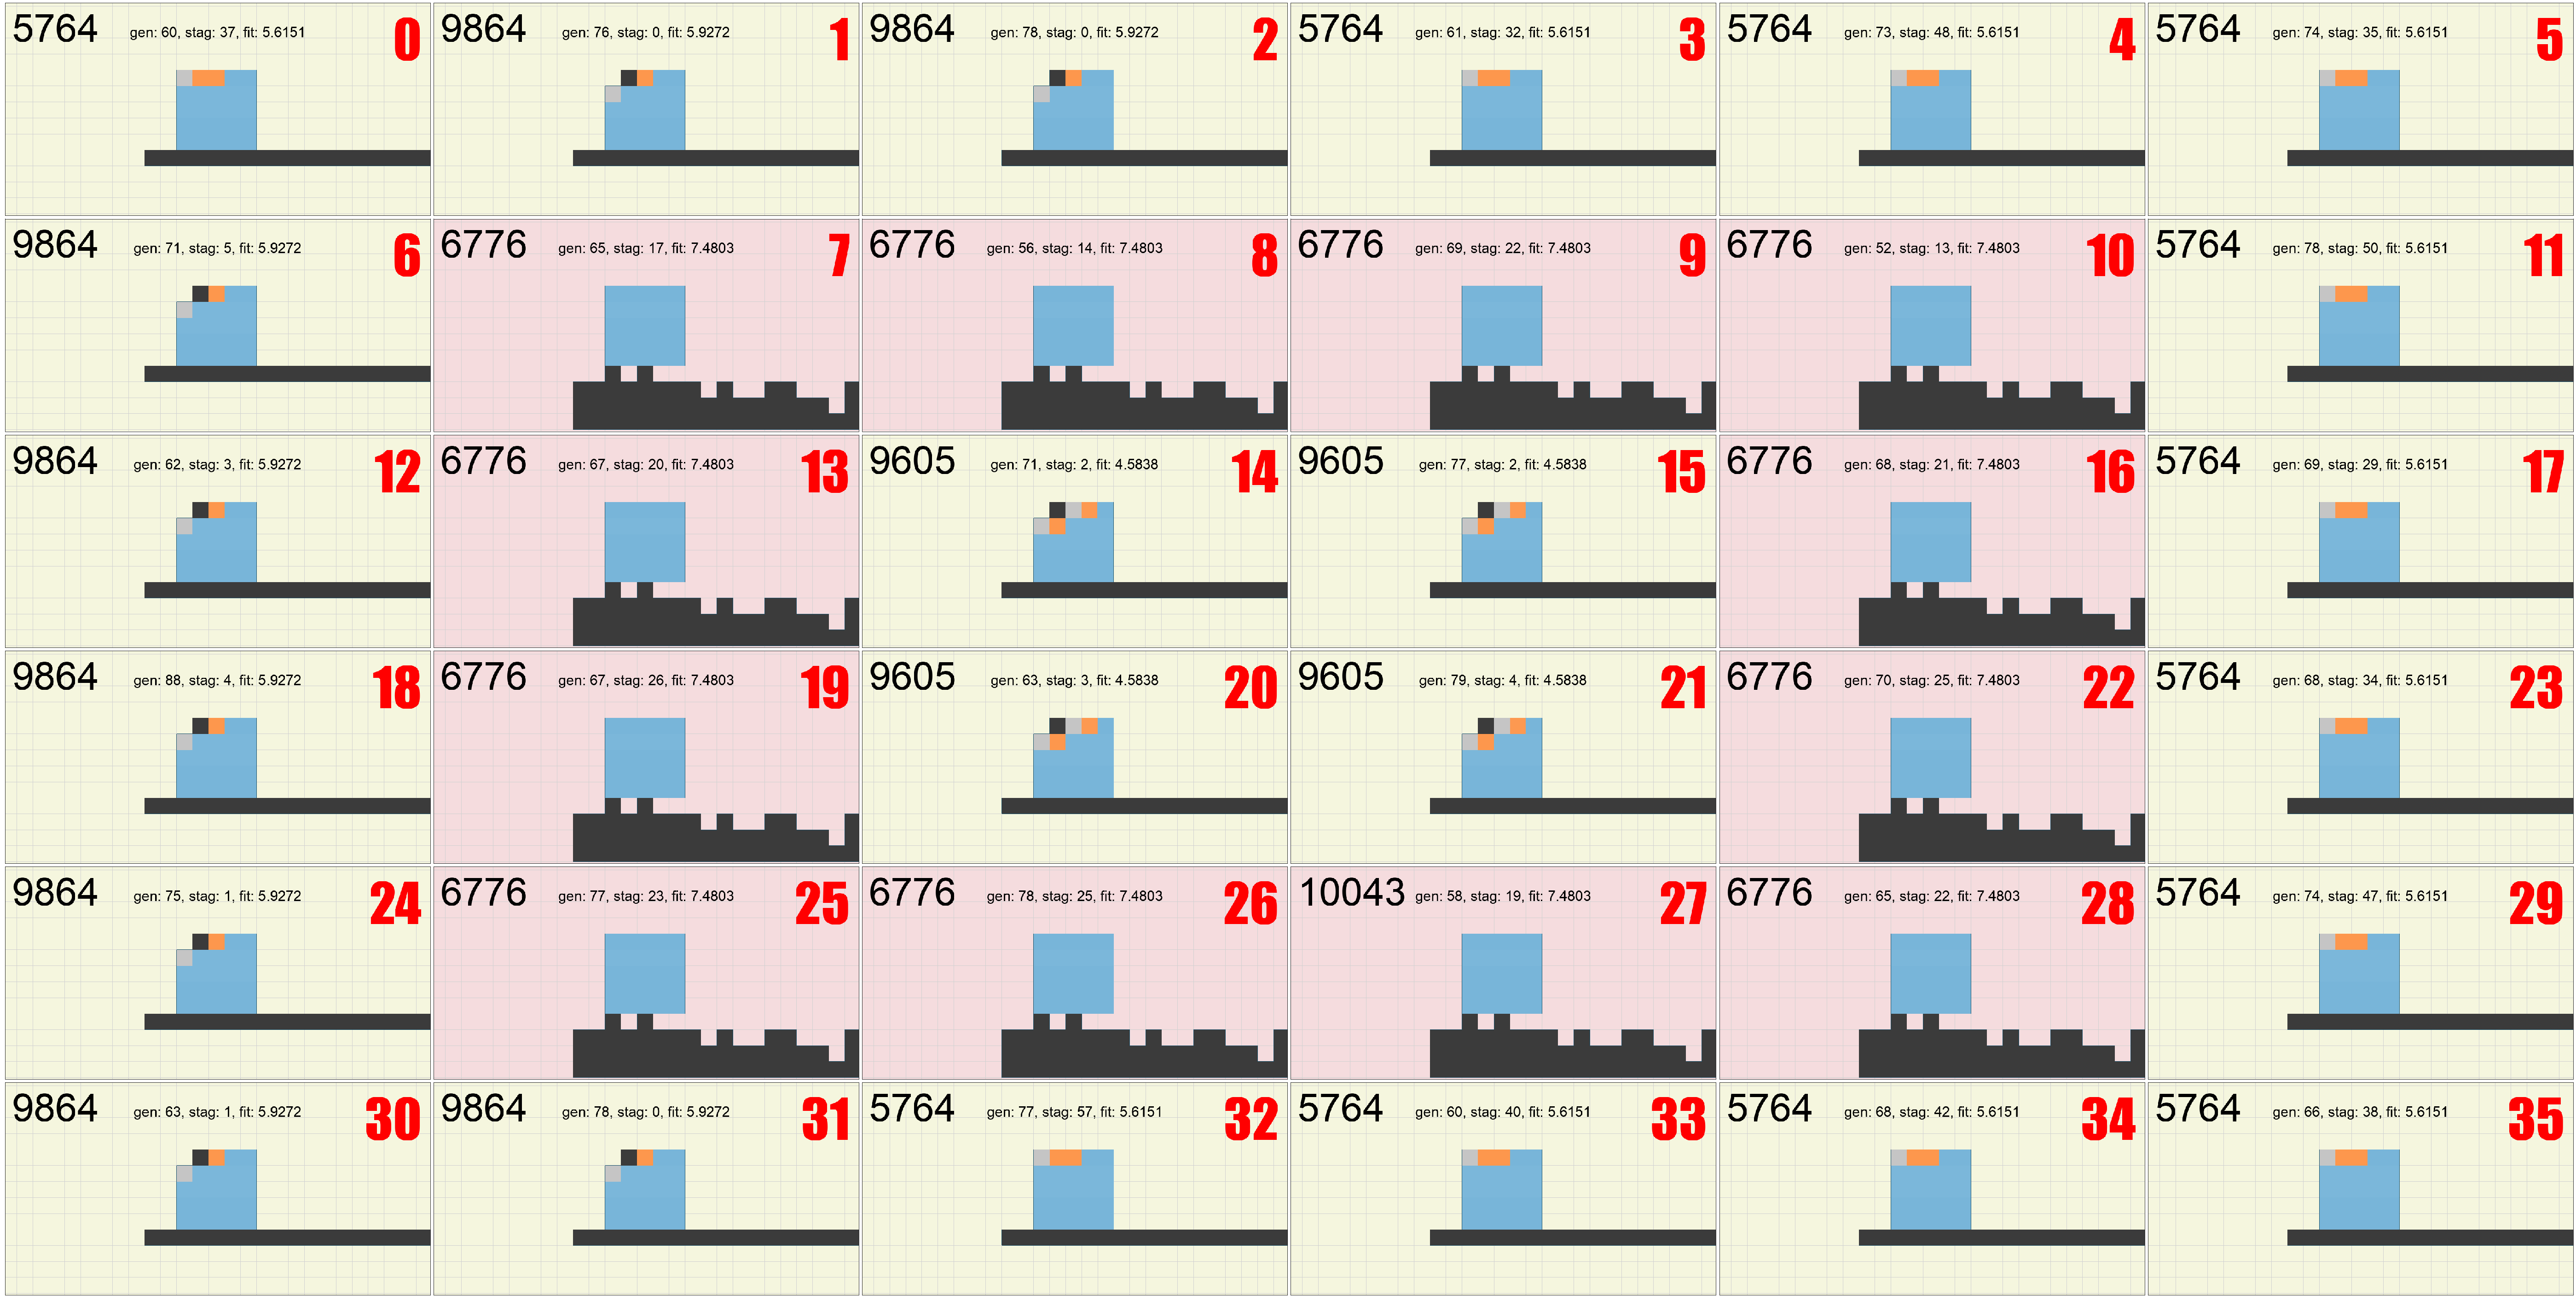

In [22]:
n_rows=6
n_cols=6
fig = generate_grid(grid, n_rows, n_cols, genome_type)

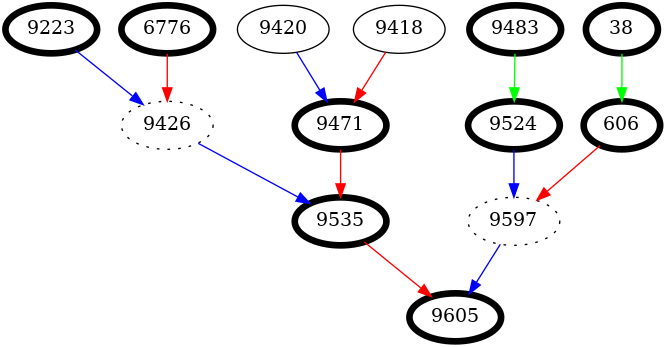

{'id': 9605, 'pop_id': 13, 'generation': 2356, 'parent_1': 9597, 'parent_2': 9535}


In [31]:
genome_id = 9605
max_depth = 3


A = pgv.AGraph(directed=True, strict=True, rankdir="TB")
create_gen_tree(grid.d_historical, A, genome_id, max_depth)
# create_gen_tree(grid.d_historical, A, 11904, max_depth)
# create_gen_tree(grid.d_historical, A, 9091, max_depth)
# create_gen_tree(grid.d_historical, A, 11136, max_depth)
# create_gen_tree(grid.d_historical, A, 11874, max_depth)

A.graph_attr["epsilon"] = "0.001"
img = IPython.display.Image(A.draw(format='png', prog='dot'))
display(img)
print(grid.d_historical[genome_id].__dict__)

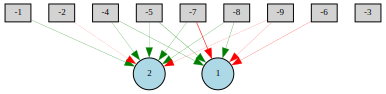

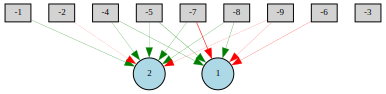

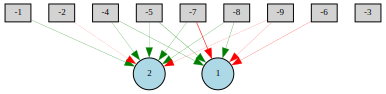

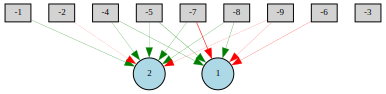

In [10]:
def draw_network(g):
    cppn = neat.nn.FeedForwardNetwork.create(g, neat_config)
    display(draw_net(cppn))
    
    
g0 = grid.d_nodes["0"].sgr_pop.best_genome
g1 = grid.d_nodes["1"].sgr_pop.best_genome
g2 = grid.d_nodes["2"].sgr_pop.best_genome
g3 = grid.d_nodes["3"].sgr_pop.best_genome

draw_network(g0)
draw_network(g1)
draw_network(g2)
draw_network(g3)


In [11]:
# print(g0.distance(g1, neat_config.genome_config))
print(g2.distance(g3, neat_config.genome_config))
print(g1.distance(g3, neat_config.genome_config))

0.0
0.0


In [12]:
task = "ObstacleTraverser-v0"
# task = "ObstacleTraverser-v1"
# task = "Hurdler-v0"
genome = grid.d_nodes["0"].sgr_pop.best_genome

r, _ = grid.d_nodes["0"].sgr_pop.single_genome_fit(
            genome = genome,
            n_steps = 800,
            env_name = task,
            get_env_obs=get_locomotion_env_obs,
            render=True, 
            save_gif=None,
            skip_evaluated=False
        )
print(r)

2.6708979206581454
